*Problem 1.1*
Visulize Mandelbrot set.

### Mandelbrot Set

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time
from scipy.stats import norm, t
from scipy.stats import qmc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [247]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter = 200):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter = 200):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image

# Compute the Mandelbrot set
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)
    

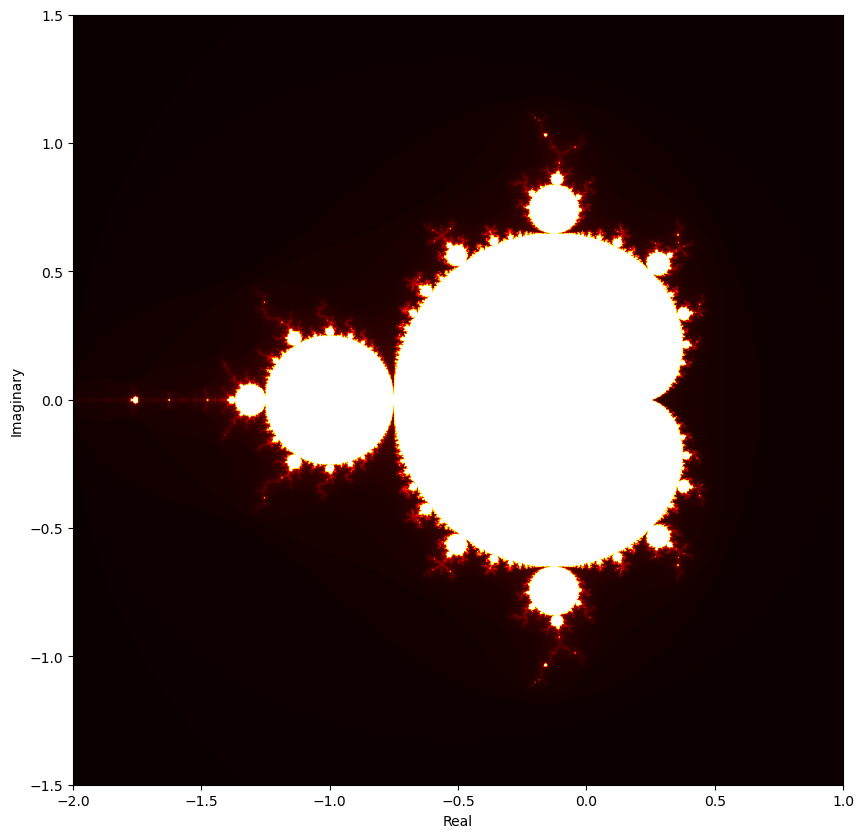

In [4]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [129]:
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap

def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 0, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 2, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


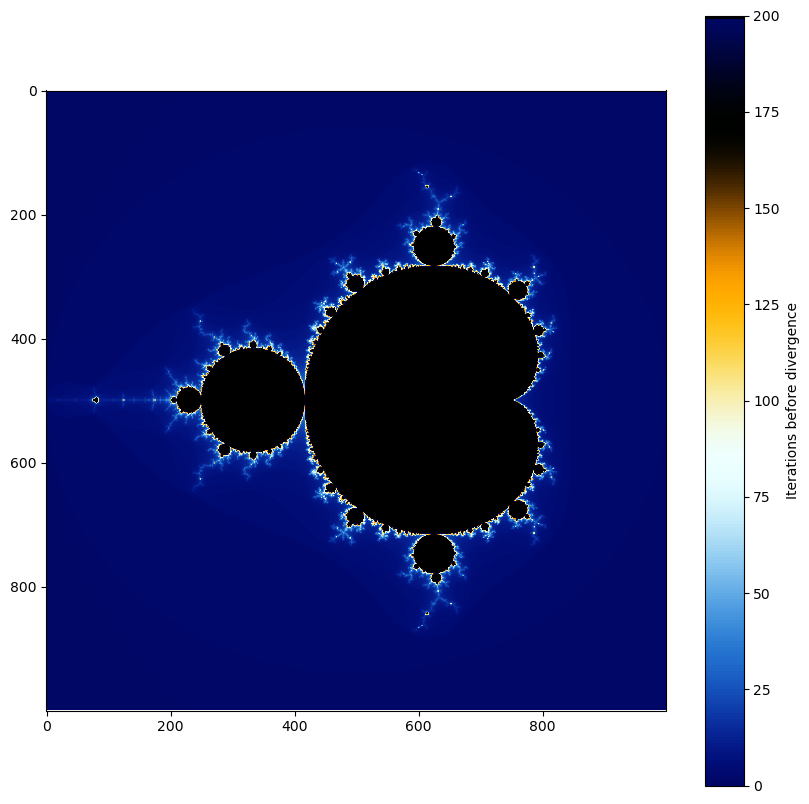

In [6]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

## Question 2

Analyze how $i$ influence $A_{is}$ when $s$ is 100000(very large).

In [249]:
# Define the pure random sampling function
def pure_random_sampling(num_samples, real_range, imag_range):
    real_samples = np.random.uniform(real_range[0], real_range[1], num_samples)
    imag_samples = np.random.uniform(imag_range[0], imag_range[1], num_samples)
    return real_samples + 1j * imag_samples

# Define a function to estimate the area of the Mandelbrot set using sampling
def estimate_area(samples, max_iter):
    inside_count = 0
    for c in samples:
        if stability(c, max_iter) == max_iter:
            inside_count += 1
    area = 9 * inside_count / len(samples)
    return area

# Define a function to calculate the convergence of areas for different values of max_iter
def convergence_curve(samples, max_iter_range):
    areas = []
    times = []
    
    for max_iter in max_iter_range:
        start_time = time()
        area = estimate_area(samples, max_iter)
        times.append(time() - start_time)
        areas.append(area)
    
    return areas, times

In [250]:
# Set parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Run the pure random sampling once and store the samples
pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)

# Calculate the convergence curve for pure random sampling with adjusted range
areas_pure_random, times_pure_random = convergence_curve(
    pure_random_samples,
    max_iter_range_adjusted
)


### Find the smallest i that meets the desired_relative_error(0.1%)

In [252]:
desired_relative_error = 0.001  # 0.1% relative error
# Initialize the minimum i and relative error
min_i = 1
min_i_index = 9999
min_i_relative_error = None
Am =  areas_pure_random[-1] # make the biggest i and s combination the Am

# Find the minimum i that satisfies the desired relative error
for i, area in enumerate(areas_pure_random):
    relative_error = abs(area - Am) / Am
    print(f"i = {max_iter_range_adjusted[i]}, relative error = {relative_error*100}%")
    if relative_error <= desired_relative_error:
        min_i = max_iter_range_adjusted[i]
        min_i_index = i  # Save the index where the condition is met
        min_i_relative_error = relative_error
        break  # Stop the loop as we found the minimum i satisfying the condition


print(f"$A_m$ is {Am}")
print(f"The minimum i that satisfies the desired relative error of {desired_relative_error*100}% is {min_i}.")
print(f"The relative error achieved is {min_i_relative_error*100}%.")
print(areas_pure_random[min_i_index])


i = 100, relative error = 2.7028643186031247%
i = 200, relative error = 1.2437959696226801%
i = 300, relative error = 0.8192309992226391%
i = 400, relative error = 0.6039586198648597%
i = 500, relative error = 0.45446391197752795%
i = 600, relative error = 0.3229085690366619%
i = 700, relative error = 0.2511511092507403%
i = 800, relative error = 0.21527237935777951%
i = 900, relative error = 0.20929259104227618%
i = 1000, relative error = 0.18537343778030727%
i = 1100, relative error = 0.16743407283382686%
i = 1200, relative error = 0.14949470788734645%
i = 1300, relative error = 0.10165640136339384%
i = 1400, relative error = 0.08969682473241673%
$A_m$ is 1.50507
The minimum i that satisfies the desired relative error of 0.1% is 1400.
The relative error achieved is 0.08969682473241673%.
1.50642


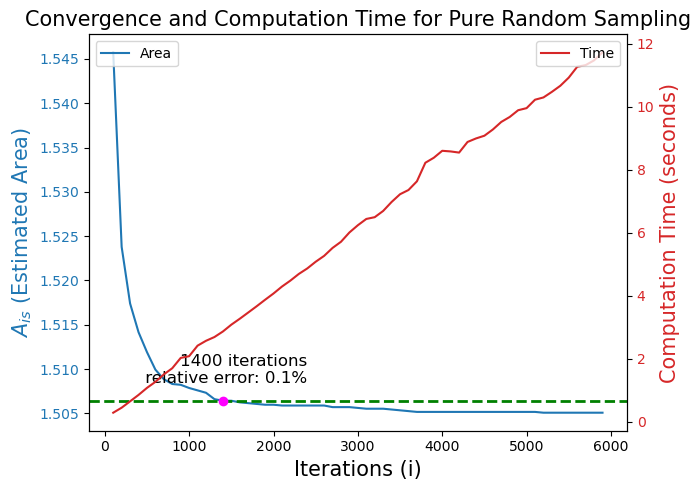

In [254]:
# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterations (i)', fontsize=15)
ax1.set_ylabel(r'$A_{is}$ (Estimated Area)', color=color, fontsize=15)
ax1.plot(max_iter_range_adjusted, areas_pure_random, label='Area', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Computation Time (seconds)', color=color, fontsize=15)
ax2.plot(max_iter_range_adjusted, times_pure_random, label='Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Convergence and Computation Time for Pure Random Sampling', fontsize = 15)

# Add a horizontal line to indicate the minimum number of iterations to satisfy the desired relative error
ax1.axhline(y=areas_pure_random[min_i_index], color='green', linestyle='--', linewidth=2)

# Annotate the minimum number of iterations and relative error
relative_error_percent = min_i_relative_error * 100
# Add a magenta point to mark the minimum i
ax1.scatter(min_i, areas_pure_random[min_i_index], color='magenta', zorder=5)
# Add text annotation next to the point
ax1.annotate(f'{min_i} iterations\n relative error: {relative_error_percent:.1f}%', 
             xy=(min_i, areas_pure_random[min_i_index]), 
             xytext=(min_i + 1000, areas_pure_random[min_i_index] + 0.002), # slight offset for readability
             fontsize=12,
             horizontalalignment='right')
plt.tight_layout()

plt.savefig("2.1 Smallest i.jpg", dpi=300)
plt.show()


### Use i = min_iter to plot Ais and relative error upon different s
This i varies. Above is 2300, but for different runs, we can get different min_i.

In [255]:
# Define the parameters for the area estimation
num_samples_start = 1000
num_samples_max = 100000
max_iter = min_i
desired_d = 0.001
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Initialize variables for the iterative process
num_samples = num_samples_start
Am_estimations = []
relative_errors = []
sample_sizes = []

# Main iterative process
while num_samples <= num_samples_max:
    # Generate samples and estimate area
    samples = pure_random_sampling(num_samples, real_range, imag_range)
    current_area = estimate_area(samples, max_iter)
    
    # Assume Am is the area estimated with the maximum number of samples
    if num_samples == num_samples_max:
        Am = current_area
    
    # Calculate relative error
    relative_error = abs(Am - current_area) / Am
    relative_errors.append(relative_error)
    Am_estimations.append(current_area)
    sample_sizes.append(num_samples)
    
    print(f"Number of samples: {num_samples}, Estimated Area: {current_area}, Relative Error: {relative_error}")
    
    # Update num_samples for next iteration
    num_samples += 1000

Number of samples: 1000, Estimated Area: 1.449, Relative Error: 0.03725408120552522
Number of samples: 2000, Estimated Area: 1.566, Relative Error: 0.04048316689589199
Number of samples: 3000, Estimated Area: 1.485, Relative Error: 0.013334927943550673
Number of samples: 4000, Estimated Area: 1.566, Relative Error: 0.04048316689589199
Number of samples: 5000, Estimated Area: 1.611, Relative Error: 0.0703821084733601
Number of samples: 6000, Estimated Area: 1.494, Relative Error: 0.00735513962805711
Number of samples: 7000, Estimated Area: 1.5852857142857142, Relative Error: 0.053296999000521095
Number of samples: 8000, Estimated Area: 1.555875, Relative Error: 0.03375590504096154
Number of samples: 9000, Estimated Area: 1.484, Relative Error: 0.013999348867494484
Number of samples: 10000, Estimated Area: 1.5336, Relative Error: 0.018955928960114922
Number of samples: 11000, Estimated Area: 1.494, Relative Error: 0.00735513962805711
Number of samples: 12000, Estimated Area: 1.5075, Rela

In [107]:
print(max_iter)

2000


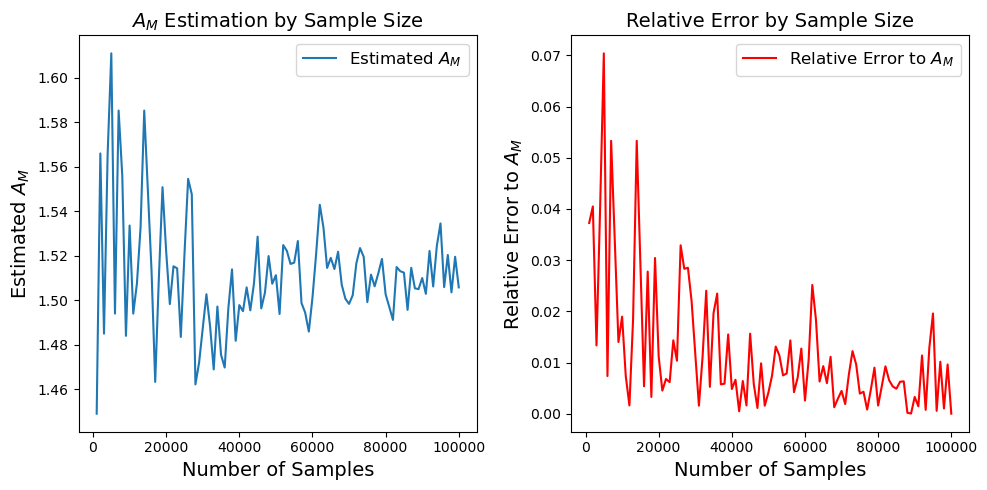

In [256]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plot Am estimations
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, Am_estimations, label=r'Estimated $A_M$')
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel(r'Estimated $A_M$', fontsize=14)
plt.title(r'$A_M$ Estimation by Sample Size', fontsize=14)
plt.legend(fontsize = 12)



# Plot relative errors
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, relative_errors, label=r'Relative Error to $A_M$', color='red')
plt.xlabel('Number of Samples',  fontsize=14)
plt.ylabel(r'Relative Error to $A_M$', fontsize=14)
plt.title('Relative Error by Sample Size', fontsize=14)
plt.legend(fontsize = 12)

plt.tight_layout()
plt.savefig("2.2 different s.jpg", dpi = 300)
plt.show()


Too much stochasticity.

### Find s using confidence interval(significance level = 95%)
For each s, we run n times(n>30) and we apply CLT to calculate how certain We are the $A_M$ will fall within the confidence interval.


In [261]:
# Define the function to encapsulate the confidence interval calculation
def calculate_confidence_intervals(sampling_method, sample_sizes, real_range, imag_range, n, max_iter):
    conf_interval_radii = []
    mean_areas = []
    # Perform the area estimation for each sample size
    for s in sample_sizes:
        area_estimates = []
        for _ in range(n):
            samples = sampling_method(s, real_range, imag_range)
            area = estimate_area(samples, max_iter)
            area_estimates.append(area)
        # Calculate the mean and standard deviation of the area estimates
        mean_area_eastimated = np.mean(area_estimates)
        mean_areas.append(mean_area_eastimated)
        std_area_estimated = np.std(area_estimates, ddof=1)
        # Calculate the 95% confidence interval radius
        z_score = norm.ppf(0.975)
        conf_radius = z_score * (std_area_estimated / np.sqrt(s))
        conf_interval_radii.append(conf_radius)
    
    return np.array(conf_interval_radii), np.array(mean_areas)


In [303]:
# Example usage
sample_sizes = np.arange(100, 10001, 500)
n = 30  # number of times to sample for each sample size

# Calculate confidence intervals for pure random sampling
conf_intervals_pure_random, mean_areas_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

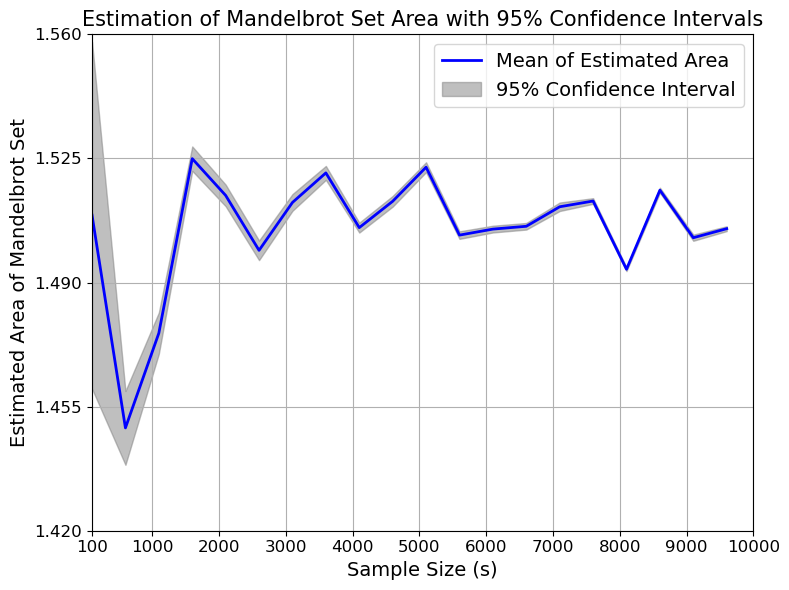

1400


In [304]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mean_areas_random, label='Mean of Estimated Area', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_pure_random, 
                 mean_areas_random + conf_intervals_pure_random, color='gray', alpha=0.5, 
                 label='95% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 95% Confidence Intervals', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
plt.ylim(bottom=min(mean_areas_random - conf_intervals_pure_random), top=max(mean_areas_random + conf_intervals_pure_random))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([sample_sizes[0]] + list(range(1000, sample_sizes[-1]+1000, 1000)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.3 mean value and confidence intervals.jpg", dpi=300)
plt.show()
print(max_iter)

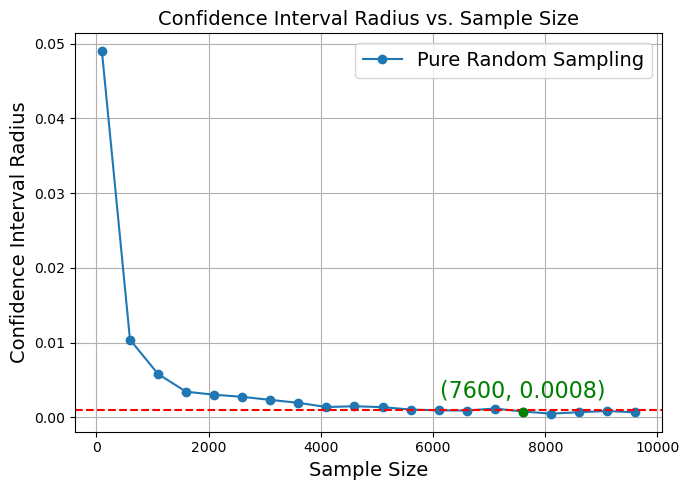

In [311]:
def mark_min_confidence_interval(sample_sizes, conf_intervals, threshold=0.001, notationcolor='g'):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return

    # Find the first index that satisfies the condition and ensure that all subsequent sample sizes also satisfy the condition
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]

    plt.plot(min_s, min_conf_interval, notationcolor+'o')  # Mark with circle
    plt.annotate(f'({min_s}, {min_conf_interval:.4f})', 
                 (min_s, min_conf_interval), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 fontsize = 16,
                 ha='center',
                 color = notationcolor)

# Plotting the confidence interval radius as a function of sample size for each method
plt.figure(figsize=(7, 5))
plt.plot(sample_sizes, conf_intervals_pure_random, marker='o', label='Pure Random Sampling')

# Adding a horizontal line at y = 0.001
plt.axhline(y=0.001, color='red', linestyle='--')

mark_min_confidence_interval(sample_sizes, conf_intervals_pure_random)

plt.xlabel('Sample Size', fontsize = 14)
plt.ylabel('Confidence Interval Radius', fontsize = 14)
plt.title('Confidence Interval Radius vs. Sample Size', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig("2.4 confidence interval radius.jpg", dpi = 300)
plt.show()

### Question 3: Use other sampling methods and run comparative analysis

In [312]:
def latin_hypercube_sampling(num_samples, real_range, imag_range):
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d = 2)  # We have two dimensions: real and imaginary
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def orthogonal_sampling(num_samples, real_range, imag_range):
    # Create an Orthogonal Sampler
    sampler = qmc.LatinHypercube(d = 2, strength = 2)
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def sieve_of_eratosthenes(n):
    """Return an array of prime numbers up to n."""
    sieve = np.ones(n + 1, dtype=bool)
    sieve[:2] = False  # 0 and 1 are not prime numbers
    for i in range(2, int(n ** 0.5) + 1):
        if sieve[i]:
            sieve[i*i:n+1:i] = False
    return np.nonzero(sieve)[0]


#### Plot the confidence interval of these 3 sampling methods. Compare the convergence.

In [318]:
# Generate a large enough array of prime numbers since orthogonal_sampling only takes prime number's square as sample size
base_numbers = sieve_of_eratosthenes(100)[3:-1]  # Adjust the number here based on how many primes you need.107th prime number = 
# Square each number to get the sample sizes
sample_sizes = base_numbers**2

# Example usage with pure_random_sampling as the sampling method
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])
n = 30  # number of times to sample for each sample size

# Calculate confidence intervals and mean areas for each sampling method
conf_intervals_random, mean_areas_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_latin, mean_areas_latin = calculate_confidence_intervals(
    latin_hypercube_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_orthogonal, mean_areas_orthogonal = calculate_confidence_intervals(
    orthogonal_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

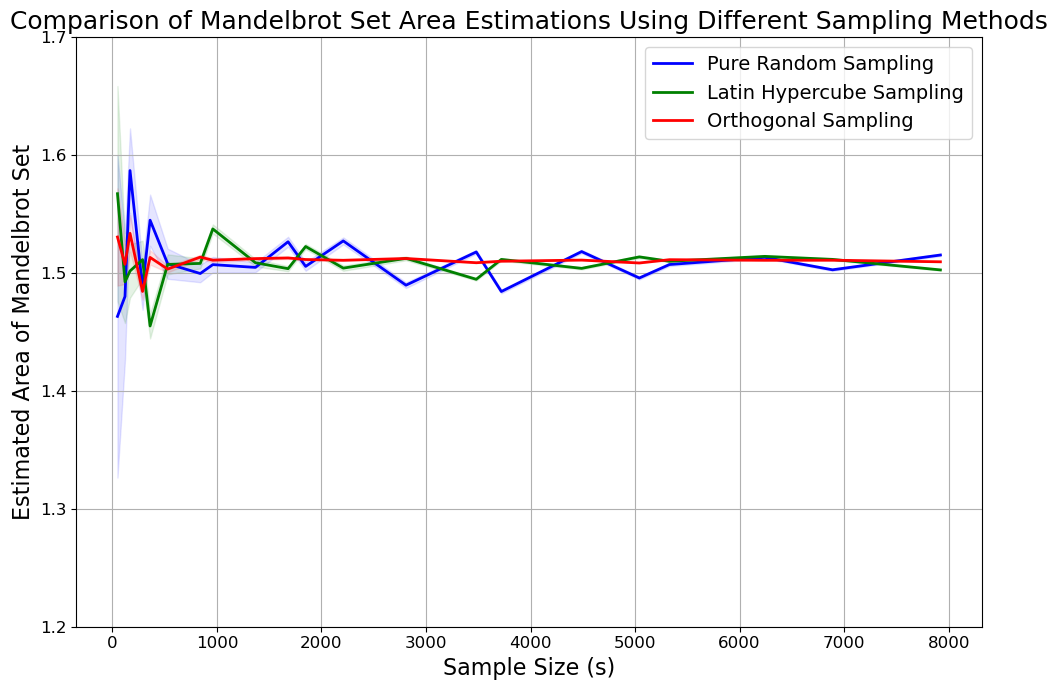

1400


In [320]:
# Plot the results for all three sampling methods on the same plot
plt.figure(figsize=(10, 7))

# Plot for Pure Random Sampling
plt.plot(sample_sizes, mean_areas_random, label='Pure Random Sampling', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_random, mean_areas_random + conf_intervals_random,
                 color='blue', alpha=0.1)

# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, mean_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_latin - conf_intervals_latin, mean_areas_latin + conf_intervals_latin,
                color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, mean_areas_orthogonal, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_orthogonal - conf_intervals_orthogonal, mean_areas_orthogonal + conf_intervals_orthogonal,
                color='red', alpha=0.1)

# Set chart title and labels with specified font sizes
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=18)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1.2, 1.7)
plt.tight_layout()
plt.savefig("3.1 Ais complete.jpg", dpi=300)
plt.show()
print(max_iter)

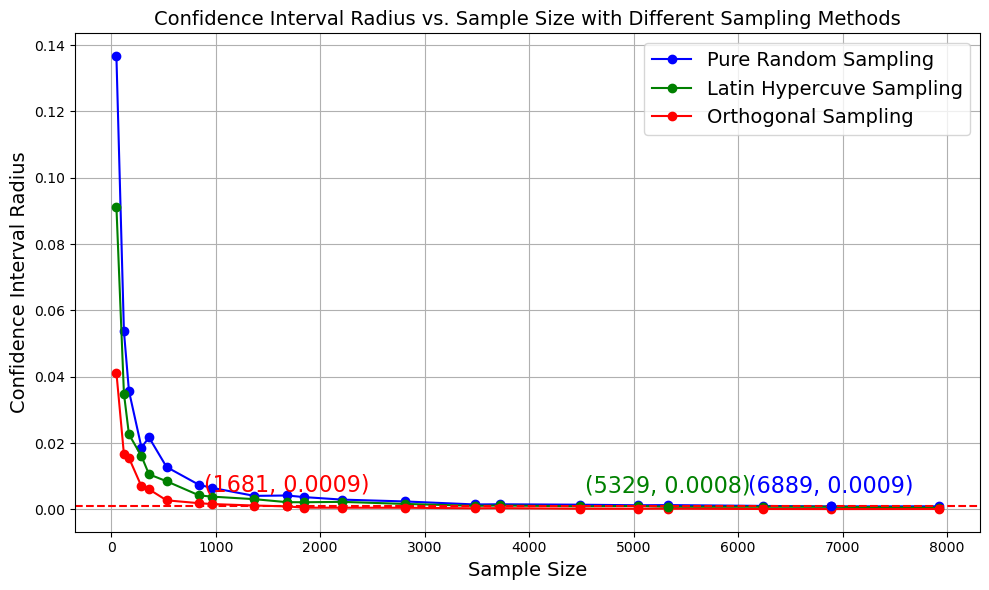

In [327]:
# Plot the results for all three sampling methods on the same plot
plt.figure(figsize=(10, 6))
threshold = 0.001

plt.plot(sample_sizes, conf_intervals_random, marker='o', label='Pure Random Sampling', color='blue')
plt.plot(sample_sizes, conf_intervals_latin, marker='o', label='Latin Hypercuve Sampling', color='green')
plt.plot(sample_sizes, conf_intervals_orthogonal, marker='o', label='Orthogonal Sampling', color='red')

# Adding a horizontal line at y = 0.001
plt.axhline(y=threshold, color='red', linestyle='--')

mark_min_confidence_interval(sample_sizes, conf_intervals_random, threshold, 'b')
mark_min_confidence_interval(sample_sizes, conf_intervals_latin, threshold, 'g')
mark_min_confidence_interval(sample_sizes, conf_intervals_orthogonal, threshold, 'r')

plt.xlabel('Sample Size', fontsize = 14)
plt.ylabel('Confidence Interval Radius', fontsize = 14)
plt.title('Confidence Interval Radius vs. Sample Size with Different Sampling Methods', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig("3.2 confidence interval radius.jpg", dpi = 300)
plt.show()



#### Plot the relative error using 3 methods. Compare the curve and the min s.

From the figure above, we can see the confidence level for different sampling methods with same i and same s are quite similar. 
HAha! It proves... so little.
Now lets try the old fashioned way.

Now we define relative_error as Ais/Am to see how the sampling method influence the Ais.

Now we take each(i,s) combination for repetitions to simulate the variance and mean.

In [328]:
base_numbers = sieve_of_eratosthenes(100)
sample_sizes = base_numbers**2
# Lists to store mean error and standard deviation for each sample size and method
mean_errors_pure = []
mean_errors_latin = []
mean_errors_ortho = []
std_dev_pure = []
std_dev_latin = []
std_dev_ortho = []

# Iterate over each sample size
for s in sample_sizes:
    # Lists to store the errors for this sample size for each method
    errors_pure = []
    errors_latin = []
    errors_ortho = []
    
    # Perform the area estimation 10 times for each sample size
    for _ in range(30):
        # Pure Random Sampling
        samples_pure = pure_random_sampling(s, real_range, imag_range)
        area_pure = estimate_area(samples_pure, max_iter)
        errors_pure.append(abs(Am - area_pure)/Am)

        # Latin Hypercube Sampling
        samples_latin = latin_hypercube_sampling(s, real_range, imag_range)
        area_latin = estimate_area(samples_latin, max_iter)
        errors_latin.append(abs(Am - area_latin)/Am)

        # Orthogonal Sampling
        samples_ortho = orthogonal_sampling(s, real_range, imag_range)
        area_ortho = estimate_area(samples_ortho, max_iter)
        errors_ortho.append(abs(Am - area_ortho)/Am)
    
    # Calculate the mean error and standard deviation for this sample size for each method
    mean_errors_pure.append(np.mean(errors_pure))
    std_dev_pure.append(np.std(errors_pure))
    mean_errors_latin.append(np.mean(errors_latin))
    std_dev_latin.append(np.std(errors_latin))
    mean_errors_ortho.append(np.mean(errors_ortho))
    std_dev_ortho.append(np.std(errors_ortho))

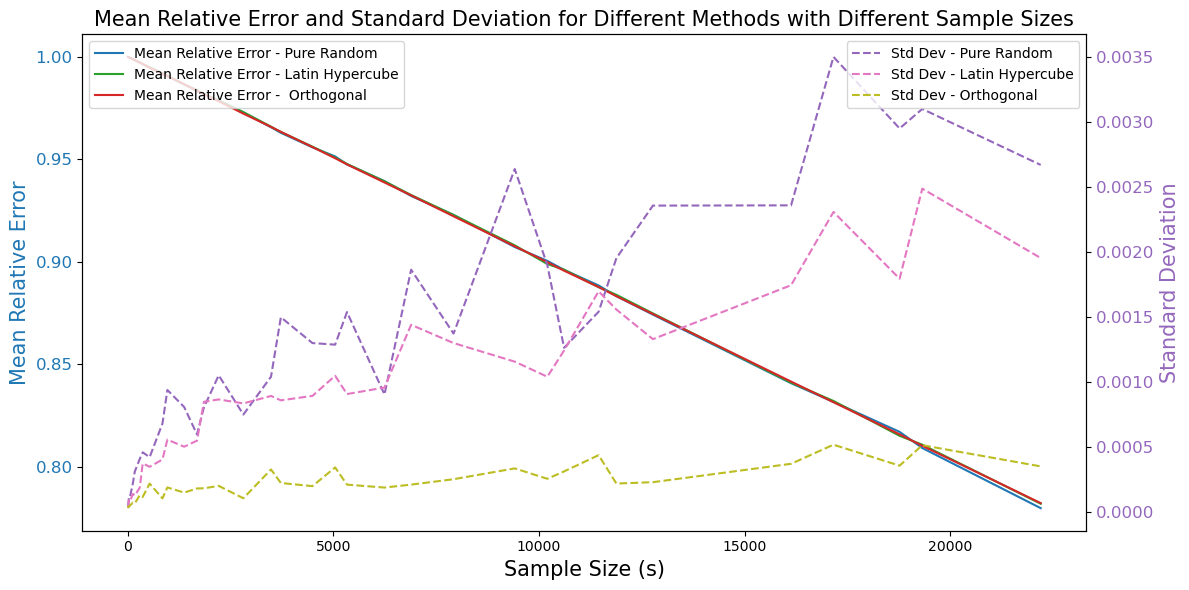

In [92]:
# Plotting the mean error and standard deviation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean error
ax1.set_xlabel('Sample Size (s)', fontsize = 15)
ax1.set_ylabel('Mean Relative Error', color='tab:blue', fontsize = 15)
ax1.plot(sample_sizes, mean_errors_pure, label='Mean Relative Error - Pure Random', color='tab:blue')
ax1.plot(sample_sizes, mean_errors_latin, label='Mean Relative Error - Latin Hypercube', color='tab:green')
ax1.plot(sample_sizes, mean_errors_ortho, label='Mean Relative Error -  Orthogonal', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize = 12)

# Create a second y-axis for the standard deviation
ax2 = ax1.twinx()
ax2.set_ylabel('Standard Deviation', color='tab:purple',fontsize = 15)
ax2.plot(sample_sizes, std_dev_pure, label='Std Dev - Pure Random', color='tab:purple', linestyle='--')
ax2.plot(sample_sizes, std_dev_latin, label='Std Dev - Latin Hypercube', color='tab:pink', linestyle='--')
ax2.plot(sample_sizes, std_dev_ortho, label='Std Dev - Orthogonal', color='tab:olive', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize = 12)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(fontsize=12)

plt.title('Mean Relative Error and Standard Deviation for Different Methods with Different Sample Sizes', fontsize = 15)
plt.tight_layout()
plt.savefig('3.6 mean and standard deviation of relative error.jpg', dpi = 300)
plt.show()


### Other things we tried to do in Q2 and Q3:
- T test.
  
  For a given sample point, there are two possible states: either the point lies within the Mandelbrot set, denoted as 1, or it does not, denoted as 0. For a set of sample points, the sample mean is denoted as: 
\begin{equation}
    \bar{X} = p
\end{equation}
And the standard deviation of the sample mean is given by 
\begin{equation}
    \frac{S}{\sqrt{n}} = \sqrt{\frac{p(1-p)}{s}}
\end{equation}
The true mean is denoted by 
\begin{equation}
    \theta = \frac{A_M}{9} 
\end{equation}
where $A_M$ is defined as the biggest i and biggest s we can use(computation time acceptable) to calculate the $A_{is}$.
According to the Central Limit Theorem, the standardized variable $\frac{\bar{X} - \theta}{\sigma/\sqrt{n}}$ follows a T distribution with the freedom of s-1.
- Difine \varepsilon = confidence interval raidus / mean value of samples. Study how this varies when increasing s.

They are all based on we have the $A_M$ as defined by the biggest i and biggest s we can use(computation time acceptable) to calculate the $A_{is}$, which turns out to be not the main target for our assignment. But we did spend a lot of time on doing things above.